Saved 4000 matrices to train_5x5_eigen_data.csv.
Saved 300 matrices to test_5x5_eigen_data.csv.
Iter 1/700, best_train_MSE=20889.977226
Iter 51/700, best_train_MSE=20884.925401
Iter 101/700, best_train_MSE=20883.043164
Iter 151/700, best_train_MSE=20881.483199
Iter 201/700, best_train_MSE=20880.912433
Iter 251/700, best_train_MSE=20880.134692
Iter 301/700, best_train_MSE=20879.858062
Iter 351/700, best_train_MSE=20879.284964
Iter 401/700, best_train_MSE=20879.024913
Iter 451/700, best_train_MSE=20878.988537
Iter 501/700, best_train_MSE=20878.733607
Iter 551/700, best_train_MSE=20878.733607
Iter 601/700, best_train_MSE=20878.624067
Iter 651/700, best_train_MSE=20878.602203
Iter 700/700, best_train_MSE=20878.529514

ACO 5x5 results:
Test MSE: 21733.7852
Test R² : 0.1644
Predictions saved to test_5x5_eigen_data.csv


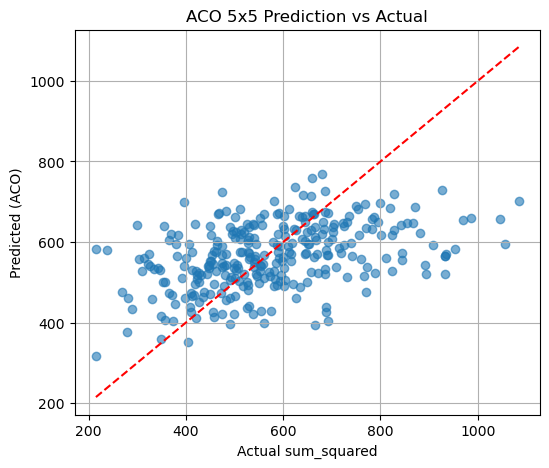

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------
# Data Generation for 5x5
# -------------------------
def generate_matrix_data_5x5(n_samples, filename, value_range=(-10, 10), include_empty_pred=False, seed=0):
    np.random.seed(seed)
    data = []

    while len(data) < n_samples:
        entries = np.random.randint(value_range[0], value_range[1] + 1, size=25)
        mat = np.array(entries).reshape(5, 5)

        eigenvalues = np.linalg.eigvals(mat)
        if np.all(np.isreal(eigenvalues)):
            eigs = np.real(eigenvalues)
            sum_sq = np.sum(eigs**2)
            row = list(entries) + list(eigs) + [sum_sq]
            if include_empty_pred:
                row.append("")
            data.append(row)

    cols = list("abcdefghijklmnopqrstuvwxyz")[:25] + ["eig1", "eig2", "eig3", "eig4", "eig5", "sum_squared"]
    if include_empty_pred:
        cols.append("predicted_sum_squared")

    df = pd.DataFrame(data, columns=cols)
    df.to_csv(filename, index=False)
    print(f"Saved {n_samples} matrices to {filename}.")

# Training and test datasets
generate_matrix_data_5x5(
    n_samples=4000,
    filename="train_5x5_eigen_data.csv",
    value_range=(-10, 10),
    include_empty_pred=False,
    seed=42
)

generate_matrix_data_5x5(
    n_samples=300,
    filename="test_5x5_eigen_data.csv",
    value_range=(-10, 10),
    include_empty_pred=True,
    seed=99
)

# -------------------------
# Feature Engineering
# -------------------------
def add_features(df):
    df = df.copy()
    letters = list("abcdefghijklmnopqrstuvwxyz")[:25]

    # Trace = sum of diagonals
    df["trace"] = df[["a", "g", "m", "s", "y"]].sum(axis=1)

    # Determinant
    def det_5x5(row):
        mat = np.array([
            row[letters[0:5]].values,
            row[letters[5:10]].values,
            row[letters[10:15]].values,
            row[letters[15:20]].values,
            row[letters[20:25]].values
        ])
        return np.linalg.det(mat)
    df["det"] = df.apply(det_5x5, axis=1)

    # Symmetry score
    def symmetry_score(row):
        mat = np.array([
            row[letters[0:5]].values,
            row[letters[5:10]].values,
            row[letters[10:15]].values,
            row[letters[15:20]].values,
            row[letters[20:25]].values
        ])
        score = 0
        for r in range(5):
            for c in range(r + 1, 5):
                score += abs(mat[r][c] - mat[c][r])
        return score
    df["sym_score"] = df.apply(symmetry_score, axis=1)
    return df

# -------------------------
# ACO Regressor (same as before)
# -------------------------
class ACORegressor:
    def __init__(self, n_ants=200, n_iter=600, top_k=20, lr=0.25,
                 sigma_init=1.0, sigma_decay=0.997, min_sigma=1e-6,
                 random_state=None, verbose=True):
        self.n_ants = n_ants
        self.n_iter = n_iter
        self.top_k = top_k
        self.lr = lr
        self.sigma_init = sigma_init
        self.sigma_decay = sigma_decay
        self.min_sigma = min_sigma
        self.random_state = random_state
        self.verbose = verbose

    def _evaluate_population(self, X, y, population):
        W = population[:, :-1]
        b = population[:, -1]
        preds = X.dot(W.T) + b.reshape(1, -1)
        mse = np.mean((preds - y.reshape(-1, 1))**2, axis=0)
        return mse

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        A = np.hstack([X, np.ones((X.shape[0], 1))])
        try:
            w0, *_ = np.linalg.lstsq(A, y, rcond=None)
            mu = w0.copy()
        except Exception:
            mu = np.zeros(X.shape[1] + 1)
        sigma = np.ones_like(mu) * self.sigma_init
        best_loss = np.inf
        best_params = mu.copy()

        for it in range(self.n_iter):
            population = rng.normal(loc=mu, scale=sigma, size=(self.n_ants, len(mu)))
            mse = self._evaluate_population(X, y, population)
            sorted_idx = np.argsort(mse)
            top_idx = sorted_idx[:self.top_k]
            top_pop = population[top_idx]
            top_mse = mse[top_idx]
            weights_inv = 1.0 / (top_mse + 1e-12)
            weights_norm = weights_inv / weights_inv.sum()
            elite_mean = (weights_norm.reshape(-1,1) * top_pop).sum(axis=0)
            mu = (1.0 - self.lr) * mu + self.lr * elite_mean
            sigma = np.maximum(sigma * self.sigma_decay, self.min_sigma)
            if mse[sorted_idx[0]] < best_loss:
                best_loss = mse[sorted_idx[0]]
                best_params = population[sorted_idx[0]].copy()
            if self.verbose and (it % 50 == 0 or it == self.n_iter - 1):
                print(f"Iter {it+1}/{self.n_iter}, best_train_MSE={best_loss:.6f}")
        self.best_params_ = best_params
        self.best_loss_ = best_loss
        return self

    def predict(self, X):
        w = self.best_params_[:-1]
        b = self.best_params_[-1]
        return X.dot(w) + b

# -------------------------
# Train/Evaluate
# -------------------------
train_df = add_features(pd.read_csv("train_5x5_eigen_data.csv"))
test_df = add_features(pd.read_csv("test_5x5_eigen_data.csv"))

letters = list("abcdefghijklmnopqrstuvwxyz")[:25]
features = letters + ["trace", "det", "sym_score"]

X_train_raw = train_df[features].values.astype(float)
y_train = train_df["sum_squared"].values.astype(float)
X_test_raw = test_df[features].values.astype(float)
y_test = test_df["sum_squared"].values.astype(float)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

aco = ACORegressor(n_ants=300, n_iter=700, top_k=30, lr=0.3, random_state=42, verbose=True)
aco.fit(X_train, y_train)

y_pred = aco.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nACO 5x5 results:")
print(f"Test MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")

# Save predictions
test_df["predicted_sum_squared"] = y_pred
test_df.to_csv("test_5x5_eigen_data.csv", index=False)
print("Predictions saved to test_5x5_eigen_data.csv")

# Plot
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Actual sum_squared")
plt.ylabel("Predicted (ACO)")
plt.title("ACO 5x5 Prediction vs Actual")
plt.grid(True)
plt.show()
